##IMPORT LIBRARY

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, classification_report, confusion_matrix
)
import joblib

##BUSSINES UNDERSTANDING##

Business Understanding & Objectives
Objective: Predict credit default (Charged Off) to minimize loss.
Key metrics: Recall for default class, ROC-AUC overall.

##DATA UNDERSTANDING

In [3]:
df = pd.read_csv('loan_data_2007_2014.csv')
print("Data shape:", df.shape)
print(df.dtypes)

Data shape: (8580, 75)
Unnamed: 0            int64
id                    int64
member_id             int64
loan_amnt             int64
funded_amnt           int64
                     ...   
all_util            float64
total_rev_hi_lim    float64
inq_fi              float64
total_cu_tl         float64
inq_last_12m        float64
Length: 75, dtype: object


In [4]:
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]
print(f"Filtered data shape: {df.shape}")

Filtered data shape: (7719, 75)


MISSING VALUES

In [5]:
missing_counts = df.isnull().sum()
print("\nMissing values per column:\n", missing_counts)
pct_missing = (missing_counts / len(df) * 100).round(2)
print("\nMissing percentage per column:\n", pct_missing)


Missing values per column:
 Unnamed: 0             0
id                     0
member_id              0
loan_amnt              0
funded_amnt            0
                    ... 
all_util            7719
total_rev_hi_lim    7719
inq_fi              7719
total_cu_tl         7719
inq_last_12m        7719
Length: 75, dtype: int64

Missing percentage per column:
 Unnamed: 0            0.0
id                    0.0
member_id             0.0
loan_amnt             0.0
funded_amnt           0.0
                    ...  
all_util            100.0
total_rev_hi_lim    100.0
inq_fi              100.0
total_cu_tl         100.0
inq_last_12m        100.0
Length: 75, dtype: float64


##DATA PREPARATION

In [6]:
# 3.1 Target definition
df['target'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})

# 3.2 Impute missing annual_inc
df['annual_inc'] = SimpleImputer(strategy='median').fit_transform(df[['annual_inc']])

# 3.3 Feature cleaning
# Extract term months
df['term_months'] = df['term'].astype(str).str.extract(r'(\d+)').astype(int)
# Clean interest rate
df['int_rate_clean'] = df['int_rate'].astype(str).str.rstrip('%').astype(float)

# 3.4 Drop outliers in annual_inc
iqr = df['annual_inc'].quantile(0.75) - df['annual_inc'].quantile(0.25)
lower = df['annual_inc'].quantile(0.25) - 1.5*iqr
upper = df['annual_inc'].quantile(0.75) + 1.5*iqr
df = df[(df['annual_inc'] >= lower) & (df['annual_inc'] <= upper)].copy()

# 3.5 Feature selection & encoding
features = ['loan_amnt', 'term_months', 'int_rate_clean', 'annual_inc', 'grade']
X = df[features].copy()
y = df['target'].copy()
# Encode grade to numeric
X['grade_encoded'] = LabelEncoder().fit_transform(X['grade'])
X.drop(columns=['grade'], inplace=True)

# 3.6 Scale numeric features
num_cols = ['loan_amnt', 'term_months', 'int_rate_clean', 'annual_inc']
X[num_cols] = StandardScaler().fit_transform(X[num_cols])

# 3.7 Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

EXPLORATORY DATA ANALYSIS (EDA)

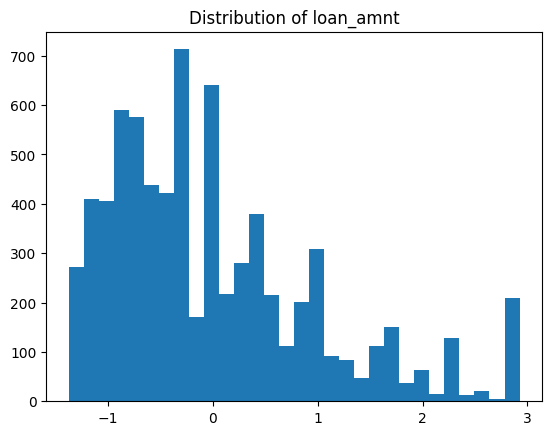

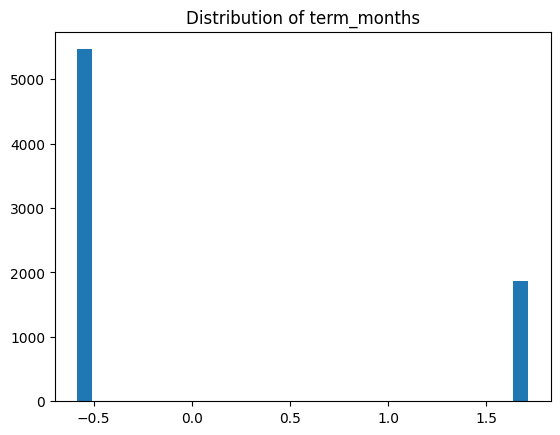

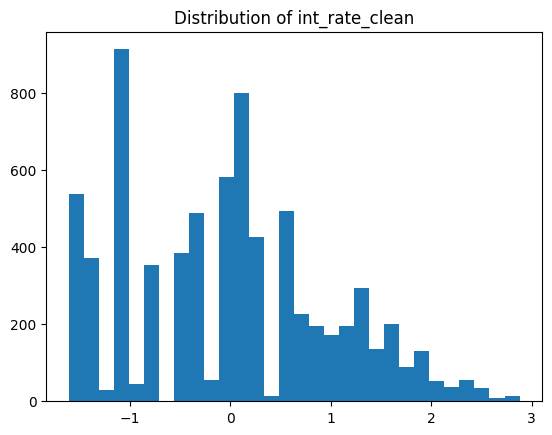

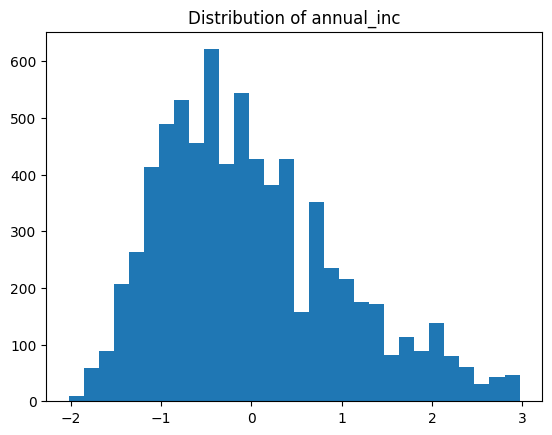

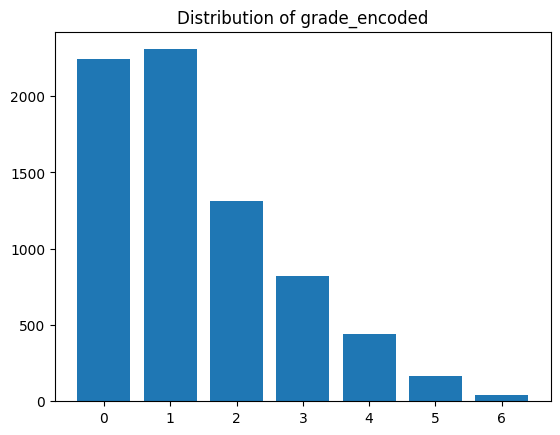

In [7]:
for col in num_cols + ['grade_encoded']:
    plt.figure()
    if col in num_cols:
        plt.hist(X[col], bins=30)
    else:
        plt.bar(X[col].value_counts().index, X[col].value_counts())
    plt.title(f'Distribution of {col}')
    plt.show()


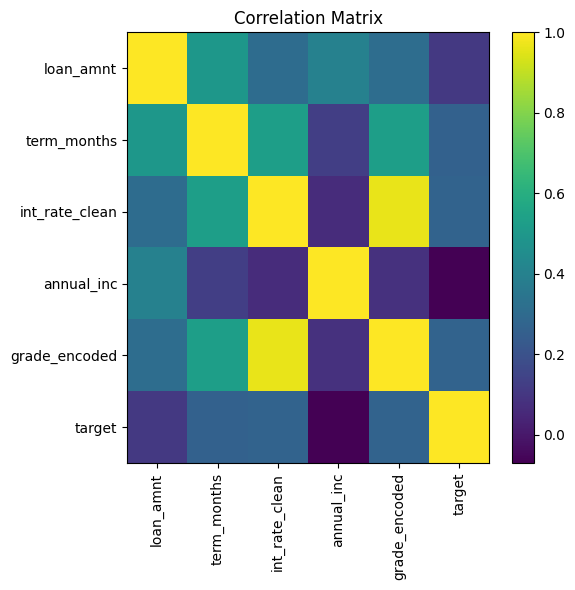

In [8]:
corr = pd.concat([X, y.rename('target')], axis=1).corr()
plt.figure(figsize=(6,6))
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.index)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

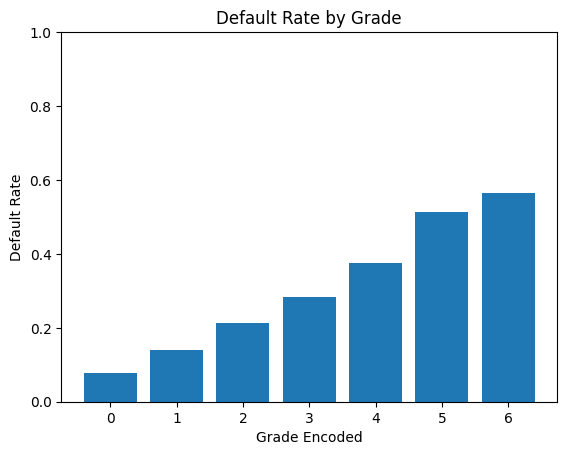

In [9]:
default_rate = y.groupby(X['grade_encoded']).mean()
plt.figure()
plt.bar(default_rate.index, default_rate.values)
plt.title('Default Rate by Grade')
plt.xlabel('Grade Encoded')
plt.ylabel('Default Rate')
plt.ylim(0,1)
plt.show()

##MODEL DEVELOPMENT

In [10]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}
grids = {
    'LogisticRegression': {'C': [0.1, 1, 10]},
    'RandomForest': {'n_estimators': [100, 200], 'max_depth': [None, 10]},
    'SVM': {'C': [0.1, 1], 'kernel': ['linear']},
    'GradientBoosting': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}
}
best_models = {}
for name, model in models.items():
    gs = GridSearchCV(model, grids[name], scoring='roc_auc', cv=5)
    gs.fit(X_train, y_train)
    best_models[name] = gs.best_estimator_
    print(f"Best {name} params: {gs.best_params_}")

Best LogisticRegression params: {'C': 1}
Best RandomForest params: {'max_depth': 10, 'n_estimators': 200}
Best SVM params: {'C': 0.1, 'kernel': 'linear'}
Best GradientBoosting params: {'learning_rate': 0.01, 'n_estimators': 200}


##MODEL EVALUATION AND SELECTION

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


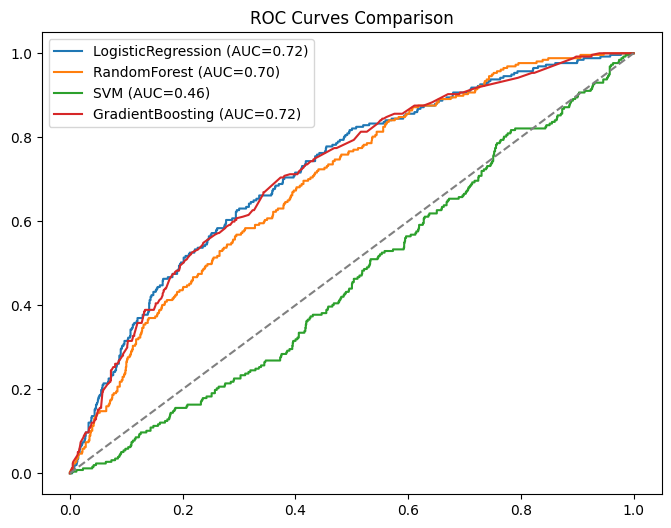

In [11]:
metrics = []
plt.figure(figsize=(8,6))
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    metrics.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC_AUC': roc_auc_score(y_test, y_proba)
    })
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test,y_proba):.2f})")
plt.plot([0,1], [0,1], '--', color='gray')
plt.title('ROC Curves Comparison')
plt.legend()
plt.show()

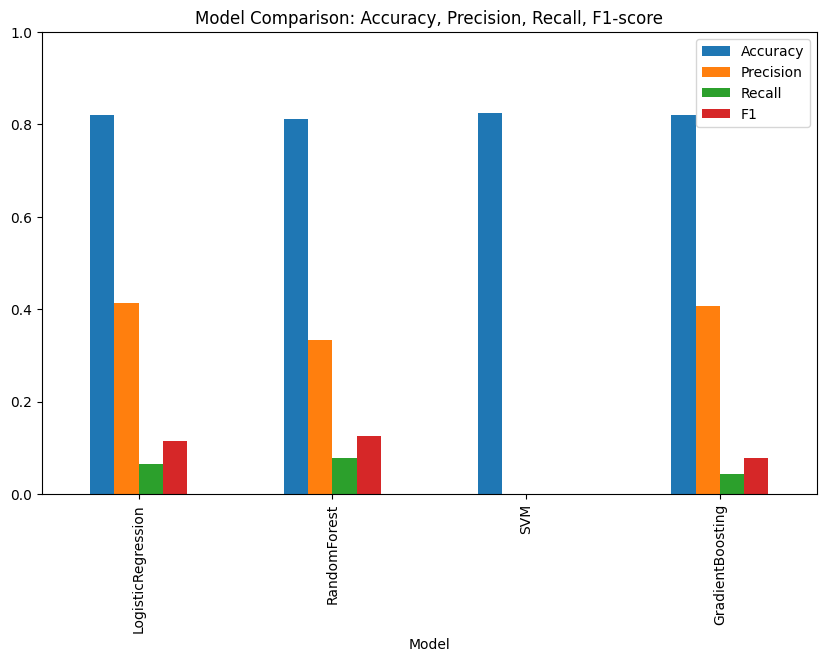

In [12]:
metrics_df = pd.DataFrame(metrics).set_index('Model')
metrics_df[['Accuracy','Precision','Recall','F1']].plot(kind='bar', figsize=(10,6))
plt.title('Model Comparison: Accuracy, Precision, Recall, F1-score')
plt.ylim(0,1)
plt.show()

##KEY INSIGHT

In [17]:
Predictions & Insights
preds = best_models['GradientBoosting'].predict(X_test)
print("Classification Report for GB:\n",classification_report(y_test,preds))
cm=confusion_matrix(y_test,preds)
print("Confusion Matrix:\n",cm)
# Insight: proportion predicted default vs actual
default_prop=preds.mean(); actual_prop=y_test.mean()
print(f"Predicted default proportion: {default_prop:.2f}, actual: {actual_prop:.2f}")
# Top features from GB
importances=pd.Series(best_models['GradientBoosting'].feature_importances_,index=X.columns).sort_values(ascending=False)
print("Top 3 features driving default:",importances.head(3).to_dict())


Classification Report for GB:
               precision    recall  f1-score   support

           0       0.83      1.00      0.90      1209
           1       0.67      0.02      0.05       257

    accuracy                           0.83      1466
   macro avg       0.75      0.51      0.47      1466
weighted avg       0.80      0.83      0.75      1466

Confusion Matrix:
 [[1206    3]
 [ 251    6]]
Predicted default proportion: 0.01, actual: 0.18
Top 3 features driving default: {'term_months': 0.541381024288182, 'int_rate_clean': 0.26104640563970044, 'annual_inc': 0.16155514334579277}


##DEPLOYMENT

In [13]:
final_model = best_models['GradientBoosting']
final_model.fit(X, y)
joblib.dump(final_model, 'final_credit_risk_model.pkl')
print("Saved final_credit_risk_model.pkl for deployment")

Saved final_credit_risk_model.pkl for deployment
